In [1]:
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
def read_uwb(filename):
    
    f = open(filename, "r")
    
    fps = float(f.readline().split()[1])
    area_start = float(f.readline().split()[1])
    area_end = float(f.readline().split()[1])
    fs = float(f.readline().split()[1])
    fc = float(f.readline().split()[1])
    prf = float(f.readline().split()[1])
    dac_min = float(f.readline().split()[1])
    dac_max = float(f.readline().split()[1])
    interations = float(f.readline().split()[1])
    duty_ = float(f.readline().split()[1])
    pulses_per_step = float(f.readline().split()[1])
    #space
    f.readline()
    # f.readline()
    # f.readline()
    lines = f.readlines()
    f.close()
    
    time = lines[0::4]
    amplitude = lines[1::4]
 
    time_list = []
    amplitude_list = []
    
    for row in time:
        time_list.append(np.fromstring(row, dtype=float, sep=" "))
        
    for row in amplitude:
        amplitude_list.append(np.fromstring(row, dtype=float, sep=" "))   
        
   
    amplitude_list = np.asarray(amplitude_list)
    
    time_list = np.asarray(time_list)
    time_list = time_list - time_list[0]
    #print(time_list)
    
    return [{"fps": fps, "area_start": area_start, "area_end": area_end, "fs": fs, "fc": fc, "prf": prf, "dac_min": dac_min,"dac_max":dac_max,"interations":interations,
            "duty_": duty_, "pulses_per_step": pulses_per_step}, time_list, amplitude_list]


## Read Data.txt 

In [110]:
filename = '2024-01-02_16-55-05.txt'
data_raw = read_uwb(filename)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (602,) + inhomogeneous part.

In [5]:
param = data_raw[0]
time = data_raw[1]
Raw_radar = data_raw[2]
print("Shape Raw Radar : ",Raw_radar.shape )

Shape Raw Radar :  (1448, 421)


In [108]:
Raw_radar 

array([[-0.0086083 ,  0.0030588 ,  0.00342971, ...,  0.00028171,
        -0.00091552,  0.00055167],
       [-0.0086083 ,  0.0030588 ,  0.00342971, ...,  0.00028171,
        -0.00091552,  0.00055167],
       [-0.0086083 ,  0.0030588 ,  0.00342971, ...,  0.00028171,
        -0.00091552,  0.00055167],
       ...,
       [-0.0086083 ,  0.0030588 ,  0.00342971, ...,  0.00028171,
        -0.00091552,  0.00055167],
       [-0.0086083 ,  0.0030588 ,  0.00342971, ...,  0.00028171,
        -0.00091552,  0.00055167],
       [-0.0086083 ,  0.0030588 ,  0.00342971, ...,  0.00028171,
        -0.00091552,  0.00055167]])

Text(0, 0.5, 'Amplitude')

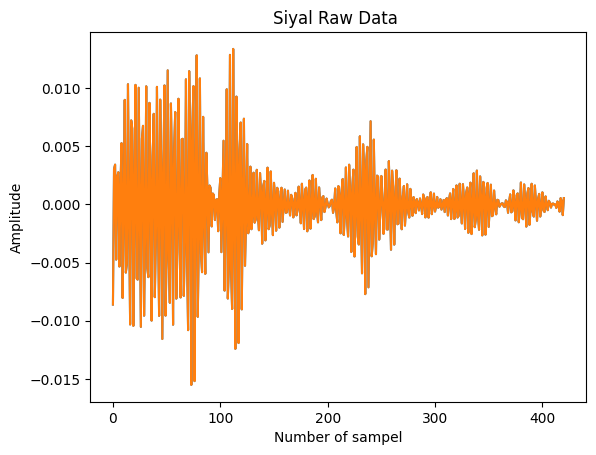

In [107]:
# Ploting Data Radar 
plt.title("Siyal Raw Data ")
plt.plot(Raw_radar[0,:])
plt.plot(Raw_radar[10,:])
plt.xlabel("Number of sampel")
plt.ylabel('Amplitude')

## Tahap Downconvertion 
* Pada tahapan ini dilakukan untuk mendapatkan sinyal baseband 

In [8]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter

def downconversion(rf_data,fc,fs):
    # multiply frame by a complex sine 
    csine = np.exp(-1j*fc/fs*2*np.pi*np.arange(rf_data.shape[1]))
    cframe = rf_data * csine
    
    # low pass filter with a hamming low pass tps = 26   
    taps = 26
    cut_off = 0.1
    h = signal.firwin(taps, cut_off, window='hamming')
    
    baseband_data = []
    
    for i in range(rf_data.shape[0]):
        baseband_data.append(signal.filtfilt(h, 1.0, cframe[i,:]))
        
    baseband_data = np.asarray(baseband_data)
    
    return baseband_data

In [9]:
def RF_downconversion(data,fc,fs):
    baseband = True 
    data = downconversion(data, fc, fs)
    return data 

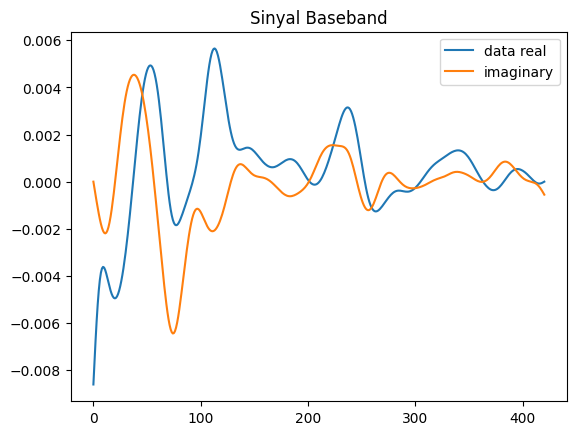

In [13]:
# Berikut adalah hasil raw data baseband
data_baseband = RF_downconversion(Raw_radar, param['fc'],param['fs'])
# Ploting baseband
col1 = data_baseband[0,:]
plt.title("Sinyal Baseband")
plt.plot(col1.real, label='data real')
plt.plot(col1.imag, label='imaginary')
plt.legend()

In [14]:
slowtime_axis = np.linspace(0, Raw_radar.shape[1], Raw_radar.shape[1], endpoint=False) 
fs = param['fs']
fps = param['fps']
fps

20.0

Text(0.5, 0, 'Range (m)')

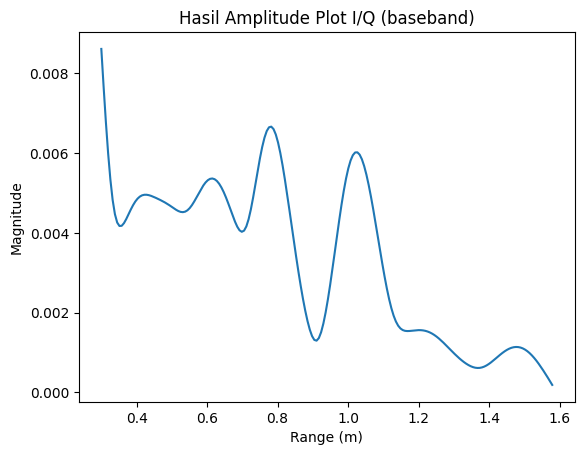

In [19]:
# Parameter-parameter yang digunakan 
fasttime_size = Raw_radar.shape[1]
distance_axis = np.linspace(param["area_start"], param["area_end"], fasttime_size, endpoint=True)
mag = abs(data_baseband[0,:])
plt.plot(distance_axis[:200], mag[:200])
plt.title('Hasil Amplitude Plot I/Q (baseband)')
plt.ylabel("Magnitude")
plt.xlabel("Range (m)")

Text(0.5, 0, 'Range (m)')

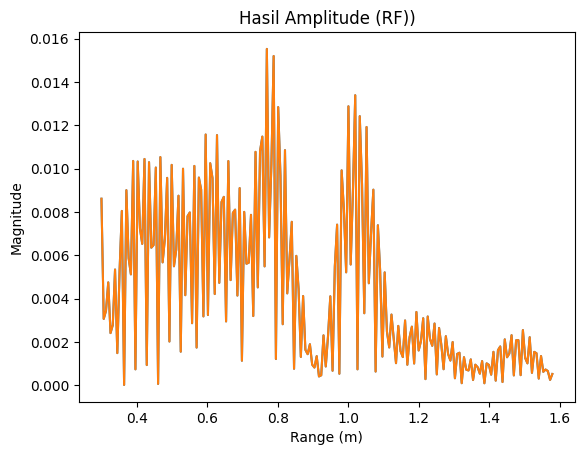

In [106]:
mag1 = abs(Raw_radar[0,:])
mag2 = abs(Raw_radar[150,:])
plt.plot(distance_axis[:200], mag1[:200])
plt.plot(distance_axis[:200], mag2[:200])
plt.title('Hasil Amplitude (RF))')
plt.ylabel("Magnitude")
plt.xlabel("Range (m)")

## Ploting Range Doppler 

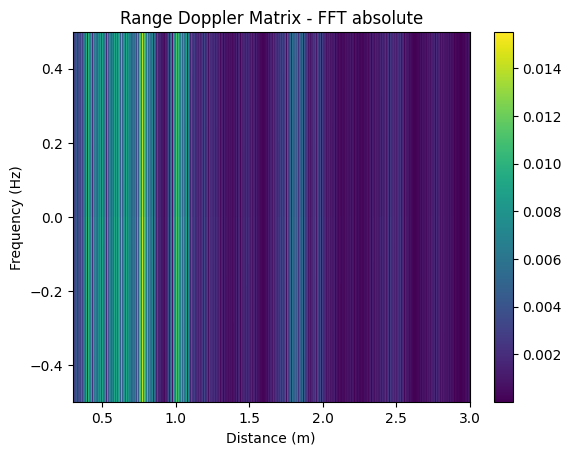

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack as sfft

def cut_spectrum(fs, z, cut):
    return fs[:cut], z[:cut, :]

def plot_range_doppler_matrix(data, param, bas, freq, max_frequency_value=0):
    fasttime_size = int(data.shape[1])
    distance_axis = np.linspace(param["area_start"], param["area_end"], fasttime_size, endpoint=True)
    d = distance_axis
    fs = freq
    
    z = data
    # mti proses
    clutter = np.zeros((z.shape[0], z.shape[1]), dtype=complex)
    OutputData = np.zeros((data.shape[0], data.shape[1]), dtype=complex)
    alpha = 0.00002
    
    for j in range(1, data.shape[0]):
        clutter[j,:] = alpha * data[j,:] + (1 - alpha) * clutter[j - 1,:]
        OutputData[j,:] = data[j,:] - clutter[j, :]

    z = sfft.fftshift(OutputData[1:], axes=0)
    fs = np.array(fs)
    
    if max_frequency_value != 0:
        print("plot")
        frequency = max_frequency_value
        cut = int(np.where(fs >= frequency)[0][0])
        fs, z = cut_spectrum(fs, z, cut)

    if bas == "absolute":
        z = np.abs(z)
    elif bas == "phase":
        z = np.unwrap(np.angle(z))
    
    plt.imshow(z, extent=[d.min(), d.max(), fs.min(), fs.max()], aspect='auto')
    
    plt.xlabel('Distance (m)')
    plt.ylabel('Frequency (Hz)')

    if bas == "absolute":
        plt.title('Range Doppler Matrix - FFT absolute')
    elif bas == "phase":
        plt.title('range doppler Matrix - FFT phase')

    plt.colorbar()
    plt.show()

# Example usage:
param = param
data = Raw_radar
freq = np.fft.fftfreq(data.shape[1])
plot_range_doppler_matrix(data, param, "absolute", freq, max_frequency_value=0)


In [36]:
z = data_baseband

In [42]:
clutter = np.zeros((z.shape[0], z.shape[1]), dtype=complex)
OutputData = np.zeros((z.shape[0], z.shape[1]), dtype=complex)
alpha = 0.1

for j in range(1, z.shape[0]):
    clutter[j,:] = alpha * z[j,:] + (1 - alpha) * clutter[j - 1,:]
    OutputData[j,:] = z[j,:] - clutter[j, :]


In [46]:
data_baseband.shape

(1448, 421)

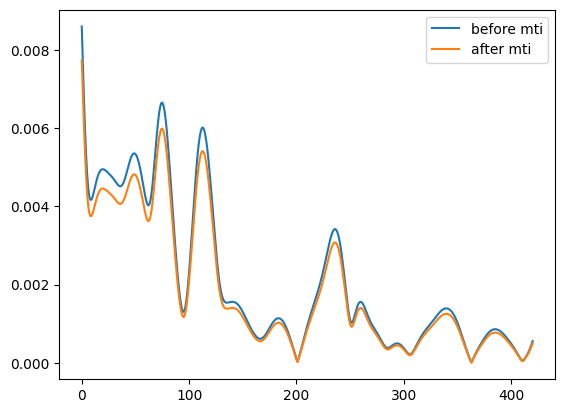

In [45]:
a = OutputData[1,:]
b = data_baseband[1,:]
plt.plot(abs(b),label='before mti')
plt.plot(abs(a),label='after mti')
plt.legend()

In [47]:
import numpy as np

# Data awal
data_awal = data_baseband

# Mengubah bentuk data
data_hasil = data_awal.T  # Menggunakan transpose

# atau
# data_hasil = data_awal.reshape((421, 1448))  # Menggunakan reshape

# Cek bentuk baru
print(data_hasil.shape)


(421, 1448)


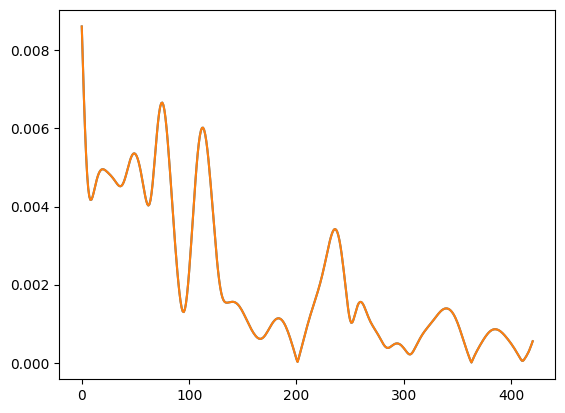

In [50]:
x = data_hasil[:,0]
plt.plot(abs(x))
plt.plot(abs(b),label='before mti')

In [55]:
data_hasil.shape[-1]

1448

In [88]:
def MTI(hasil_fft):
    clutter = np.zeros((hasil_fft.shape[0], hasil_fft.shape[1]), dtype=complex)
    OutputData = np.zeros((hasil_fft.shape[0],  hasil_fft.shape[1]), dtype=complex)
    alpha = 0.0099

    for j in range(1,hasil_fft.shape[1]):
        clutter[:, j] = alpha * hasil_fft[:, j] + (1 - alpha) * clutter[:, j-1]
        OutputData[:,j] = hasil_fft[:,j] - clutter[:, j]

    return OutputData


In [89]:
Hasil_MTI = MTI(data_hasil)
Hasil_MTI.shape

(421, 1448)

In [90]:
Hasil_mti = Hasil_MTI[:,1:]
Hasil_mti.shape

(421, 1447)

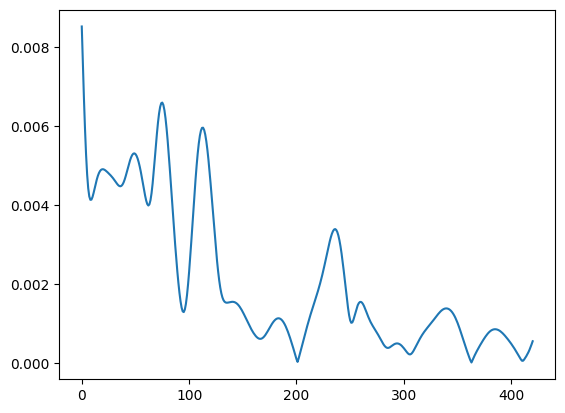

In [91]:
x1 = Hasil_mti[:,0]
plt.plot(abs(x1))

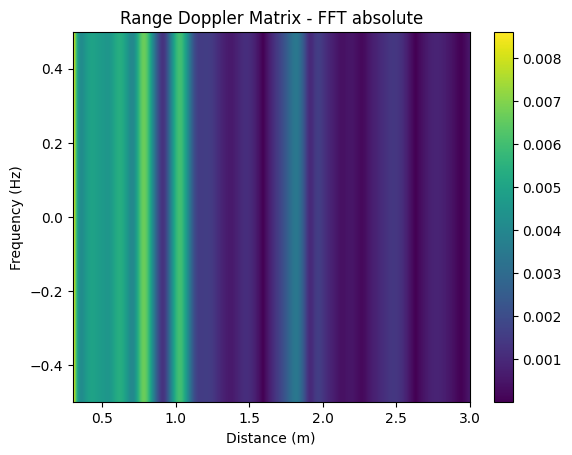

In [93]:


import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack as sfft

def cut_spectrum(fs, z, cut):
    return fs[:cut], z[:cut, :]

def plot_range_doppler_matrix(data, param, bas, freq, max_frequency_value=0):
    fasttime_size = int(data.shape[1])
    distance_axis = np.linspace(param["area_start"], param["area_end"], fasttime_size, endpoint=True)
    d = distance_axis
    fs = freq
    
    z = data
    z = sfft.fftshift(z, axes=0)
    fs = np.array(fs)
    
    if max_frequency_value != 0:
        print("plot")
        frequency = max_frequency_value
        cut = int(np.where(fs >= frequency)[0][0])
        fs, z = cut_spectrum(fs, z, cut)

    if bas == "absolute":
        z = np.abs(z)
    elif bas == "phase":
        z = np.unwrap(np.angle(z))
    
    plt.imshow(z, extent=[d.min(), d.max(), fs.min(), fs.max()], aspect='auto')
    
    plt.xlabel('Distance (m)')
    plt.ylabel('Frequency (Hz)')

    if bas == "absolute":
        plt.title('Range Doppler Matrix - FFT absolute')
    elif bas == "phase":
        plt.title('range doppler Matrix - FFT phase')

    plt.colorbar()
    plt.show()

# Example usage:
param = param
data = data_baseband
freq = np.fft.fftfreq(data.shape[1])
plot_range_doppler_matrix(data, param, "absolute", freq, max_frequency_value=0)
